# Homework
Create an RL that can balance pole in the CartPole game for 400 frames.

### Setup

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (165 kB/s)
Reading package lists... Done
Building dependency tree       
Readi

In [ ]:
import gym
from tensorflow import keras
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
import numpy as np
import random
import itertools
from collections import deque

In [ ]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 400

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
# linked list
# Store all experiences in memory, help reduce the correlations between 
# the experiences in a training batch
replay_memory = deque(maxlen=2000)

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

### Helper functions

In [ ]:
# Greedy because we select the action with the largest predicted Q value:
def policy(model, state):
  Q_values = model.predict(state[np.newaxis])
  return np.argmax(Q_values[0])

In [ ]:
# Add the resulting experience of one step in the replay memory
def add_to_memory(model, env, state):
    # define action with the policy that selects the highest Q value
    action = policy(model, state)

    # experience
    next_state, reward, done, info = env.step(action)

    # store in memory
    replay_memory.append((state, action, reward, next_state, done))
    
    return next_state, reward, done, info

In [ ]:
# Sample a random batch of experiences from the replay buffer (will return 
# 5 experience elements in 5 arrays)
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [ ]:
# Perform a Gradient Descent step on the sampled batch from replay_memory
def train(model):
  # Define hyperparameters for the model
  batch_size = 32
  discount_rate = 0.95
  optimizer = keras.optimizers.Adam(lr=1e-3)
  loss_fn = keras.losses.mean_squared_error
  
  # select sample
  states, actions, rewards, next_states, dones = sample_experiences(batch_size)

  # predict the Q value for each possible action in the next state
  next_Q_values = model.predict(next_states)
  max_next_Q_values = np.max(next_Q_values, axis=1)
  target_Q_values = (rewards +
                      (1 - dones) * discount_rate * max_next_Q_values)
  target_Q_values = target_Q_values.reshape(-1, 1)

  # mask out the possible actions that werent chosen by the agent, these arent 
  # needed
  mask = tf.one_hot(actions, n_outputs)

  # perform Gradient Descent step
  with tf.GradientTape() as tape:
      all_Q_values = model(states)
      Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
      loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=20):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

### Train

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
# best_score = 0

In [ ]:
# Define the model

inputs = keras.Input(input_shape[0])
X = keras.layers.Dense(512, input_shape=input_shape, activation="elu")(inputs)
X = keras.layers.Dense(256, activation="elu")(X)
X = keras.layers.Dense(64, activation="elu")(X)
outputs = keras.layers.Dense(n_outputs, activation="linear")(X)

dqn_model = keras.Model(inputs = inputs, outputs = outputs)
dqn_model.compile(loss="mse", optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

dqn_model.summary()

# Train the model
print(rewards)
for episode in range(600):
    obs = env.reset()    
    for step in range(400):
        # pick an action, execute and store it in memory
        obs, reward, done, info = add_to_memory(dqn_model, env, obs)
        if done:
            break

    rewards.append(step)
    # print(rewards)

    # if step > best_score:
    #     best_weights = model.get_weights()
    #     # print(best_weights)
    #     best_score = step
    print("\rEpisode: {}, Steps: {}".format(episode, step + 1), end="")
    
    # let the first 50 episodes run without training in order to use this data
    # as training data (self taught) and store in memory
    # TODO you can technically not add everything to memory and only the first
    # 50 and not mask later on
    if episode > 50:
        train(dqn_model)
# model.set_weights(best_weights)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
[]
Episode: 599, Steps: 11

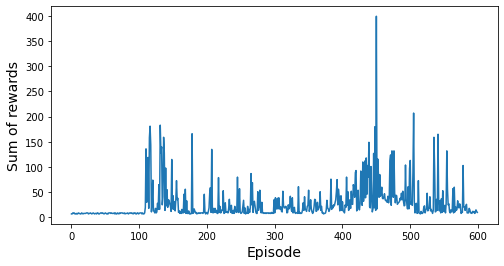

In [ ]:
# Plot trained rewards
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

### Test

In [ ]:
episode_rewards = 0
totals = []
frames = []
# def basic_policy(obs):
#   angle = obs[2]
#   return 0 if angle < 0 else 1
for step in range(50):
  obs = env.reset()
  done = False

  while not done:
    img = env.render(mode="rgb_array")
    # position, velocity, angle, angle_velocity = obs

    # action = 0 # this is a terrible policy... # accelerate left
    # action = 1 # accelerate right
    # action = random.choice([0,1])
    # action = basic_policy(obs)
    action = policy(dqn_model, obs)
    obs, reward, done, info = env.step(action)
    # print(epsilon, action)

    frames.append(img)
    episode_rewards += reward
    totals.append(episode_rewards)

print('img.shape:', img.shape)
print('env.action_space:', env.action_space) # discrete, only 1 or 2
print('len(frames):', len(frames))
print('Max number of frames balanced:', np.max(totals))
plot_animation(frames)

img.shape: (400, 600, 3)
env.action_space: Discrete(2)
len(frames): 472
Max number of frames balanced: 472.0
